In [ ]:
# default_exp analyses

# Conditional Stop Probability
> Probability of stopping recall conditional on number of items recalled so far

## Data Preparation
For our demonstrations, we'll lean on the MurdockOkada1970 dataset. 
As a reminder, in this dataset each of 72 undergraduates was given 20 test lists with 20-word lists visually presented at either 60 or 120 words/min.

In [1]:
from compmemlearn.datasets import prepare_murdock1970_data

trials, events, list_length = prepare_murdock1970_data('../../data/mo1970.txt')
events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


## Analysis

### Fast Array Generation
`DataFrame`s contain granular subject-by-subject information and are easier to plot using the `seaborn` library. 
But sometimes we don't need this granular information and mainly want to perform our analysis as quickly as possible -- perhaps to help with model fitting or analysis. 
In that case, representing results with `numpy` arrays and performing just-in-time compilation of our function using `numba` might be preferred. 
We include `analyses.fast_csp` in our library for that purpose here.

In [7]:
# export

from numba import njit
import numpy as np

@njit(fastmath=True, nogil=True)
def fast_csp(trials, item_count):
    
    # numerator is number of trials with zero in current column position
    numerator = np.zeros(item_count+1)

    # denominator is number of trials without zero in previous column positions
    denominator = np.zeros(item_count+1)

    stop_positions = trials == 0
    for i in range(len(trials)):

        # add 1 to index of final recall
        numerator[np.argmax(stop_positions[i])] += 1
        
        # add 1 to each index up through final recall
        denominator[:np.argmax(stop_positions[i])+1] += 1
        
    denominator[denominator==0] += 1
    return numerator/denominator

In [11]:
fast_csp(trials, list_length)

array([0.        , 0.00138889, 0.01877608, 0.05740609, 0.18195489,
       0.25919118, 0.33498759, 0.4608209 , 0.50519031, 0.55944056,
       0.65079365, 0.77272727, 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

### DataFrame
The `psifr` library doesn't have a function to generate `pandas` DataFrames containing conditional stop probability information, so we make our own. For efficiency, it mainly consists of calls to `fast_csp`.

In [122]:
import pandas as pd

def csp(events, trials):
    subjects = len(np.unique(events.subject))
    trial_count = np.max(events.list)
    list_length = np.max(events.input)
    
    result = {'subject': [], 'output': [], 'prob': []}
    
    for subject in range(subjects):
        subject_result = fast_csp(trials[subject*trial_count:(subject+1)*trial_count], list_length)
        subject_result[np.argmax(subject_result)+1:] = np.nan

        result['subject'] += [subject+1]*(list_length+1)
        result['output'] += np.arange(list_length+1, dtype=int).tolist()
        result['prob'] += subject_result.tolist()
        
    return pd.DataFrame(result)

In [123]:
csp(events, trials)

,subject,output,prob
0,1,0,0.0
1,1,1,0.0
2,1,2,0.0
3,1,3,0.0
4,1,4,0.0
...,...,...,...
1507,72,16,NaN
1508,72,17,NaN
1509,72,18,NaN
1510,72,19,NaN


In [124]:
%%timeit
fast_csp(trials, list_length)

210 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [125]:
%%timeit
csp(events, trials)

2.53 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`fast_csp` is slower than our serial position effect functions, but faster than our functions analyzing lag-contiguity.

## Plotting
We'll define a `seaborn`-based plotting function that uses our `csp` function.

In [130]:
# export
import seaborn as sns
from psifr import fr

def plot_csp(data, **facet_kws):
    
    trials = pd.pivot_table(
        data, index=['subject', 'list'], 
        columns=['output'], values='input', 
        fill_value=0).to_numpy()

    sns.lineplot(
        data=csp(data, trials), 
        x='output', y='prob', **facet_kws)

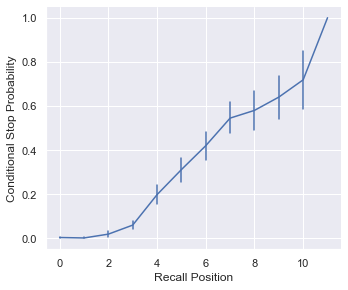

In [132]:
sns.set_theme(style="darkgrid")

g = sns.FacetGrid(dropna=False, data=events, height=4, aspect=1.2)
g.map_dataframe(plot_csp, err_style='bars')

g.set_xlabels('Recall Position')
g.set_ylabels('Conditional Stop Probability');